#  Initial Data Exploration

In [7]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
### Include all quantitative features. In addition, 'std_from_poi' and
### 'std_to_poi' are standardized feature (see details below).
features_list = ['poi','salary', 'deferral_payments',
                 'loan_advances', 'bonus', 'restricted_stock_deferred',
                 'deferred_income', 'expenses',
                 'exercised_stock_options', 'other', 'long_term_incentive',
                 'restricted_stock', 'director_fees','shared_receipt_with_poi',
                 'std_from_poi','std_to_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers

### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
# Add new features: std_from_poi and std_to_poi by dividing the message
# to/from poi by the total sent or received messages, respectively.
data_dict.pop('TOTAL')
for key in data_dict:
    if (type(data_dict[key]['from_poi_to_this_person']) == int and
        type(data_dict[key]['from_messages']) == int):
        data_dict[key]['std_from_poi'] = \
        (data_dict[key]['from_poi_to_this_person']/
         data_dict[key]['from_messages'])
    else:
        data_dict[key]['std_from_poi'] = 0
    if (type(data_dict[key]['from_this_person_to_poi']) == int and
        type(data_dict[key]['to_messages']) == int):
        data_dict[key]['std_to_poi'] = \
        (data_dict[key]['from_this_person_to_poi']/
         data_dict[key]['to_messages'])
    else:
        data_dict[key]['std_to_poi'] = 0
my_dataset = data_dict
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
# The followings are the major steps in the analysis:
# A. Visualize the data using dimensionality reduction PCA and LDA to gain
#    further insight into the data
# B. Algorithm selection using repeated nested cross validation to choose
#    the algorithm that has highest accuracy
# C. Model selection using repeated cross validation to identify the best
#    hyperparameter values

# The following classification algorithms are used:
# 1. Logistic Regression
# 2. Random Forest Classifier
# 3. KNN Classifier
# 4. Support Vector Classifier
# 5. Neural Network: Multi-layer Perceptron Classifier
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from time import time

# For simplicity, rename features as X and labels as y
X = features
y = labels
### First, explore the dataset.
### Identify the total number of data points.
print 'Total number of data points:',np.shape(X)[0]
print 'Total number of features:', np.shape(X)[1]

X_std = MinMaxScaler().fit_transform(X)
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_std)
print 'PCA explained_variance_ratio_', pca.explained_variance_ratio_

Total number of data points: 144
Total number of features: 15
PCA explained_variance_ratio_ [ 0.34009165  0.14587186  0.11865707  0.09708045  0.08427081  0.05342777
  0.03780895  0.02865871  0.02603738  0.0204774   0.01857858  0.01448915
  0.01119808  0.00335214  0.        ]


#  Scatterplot Matrix

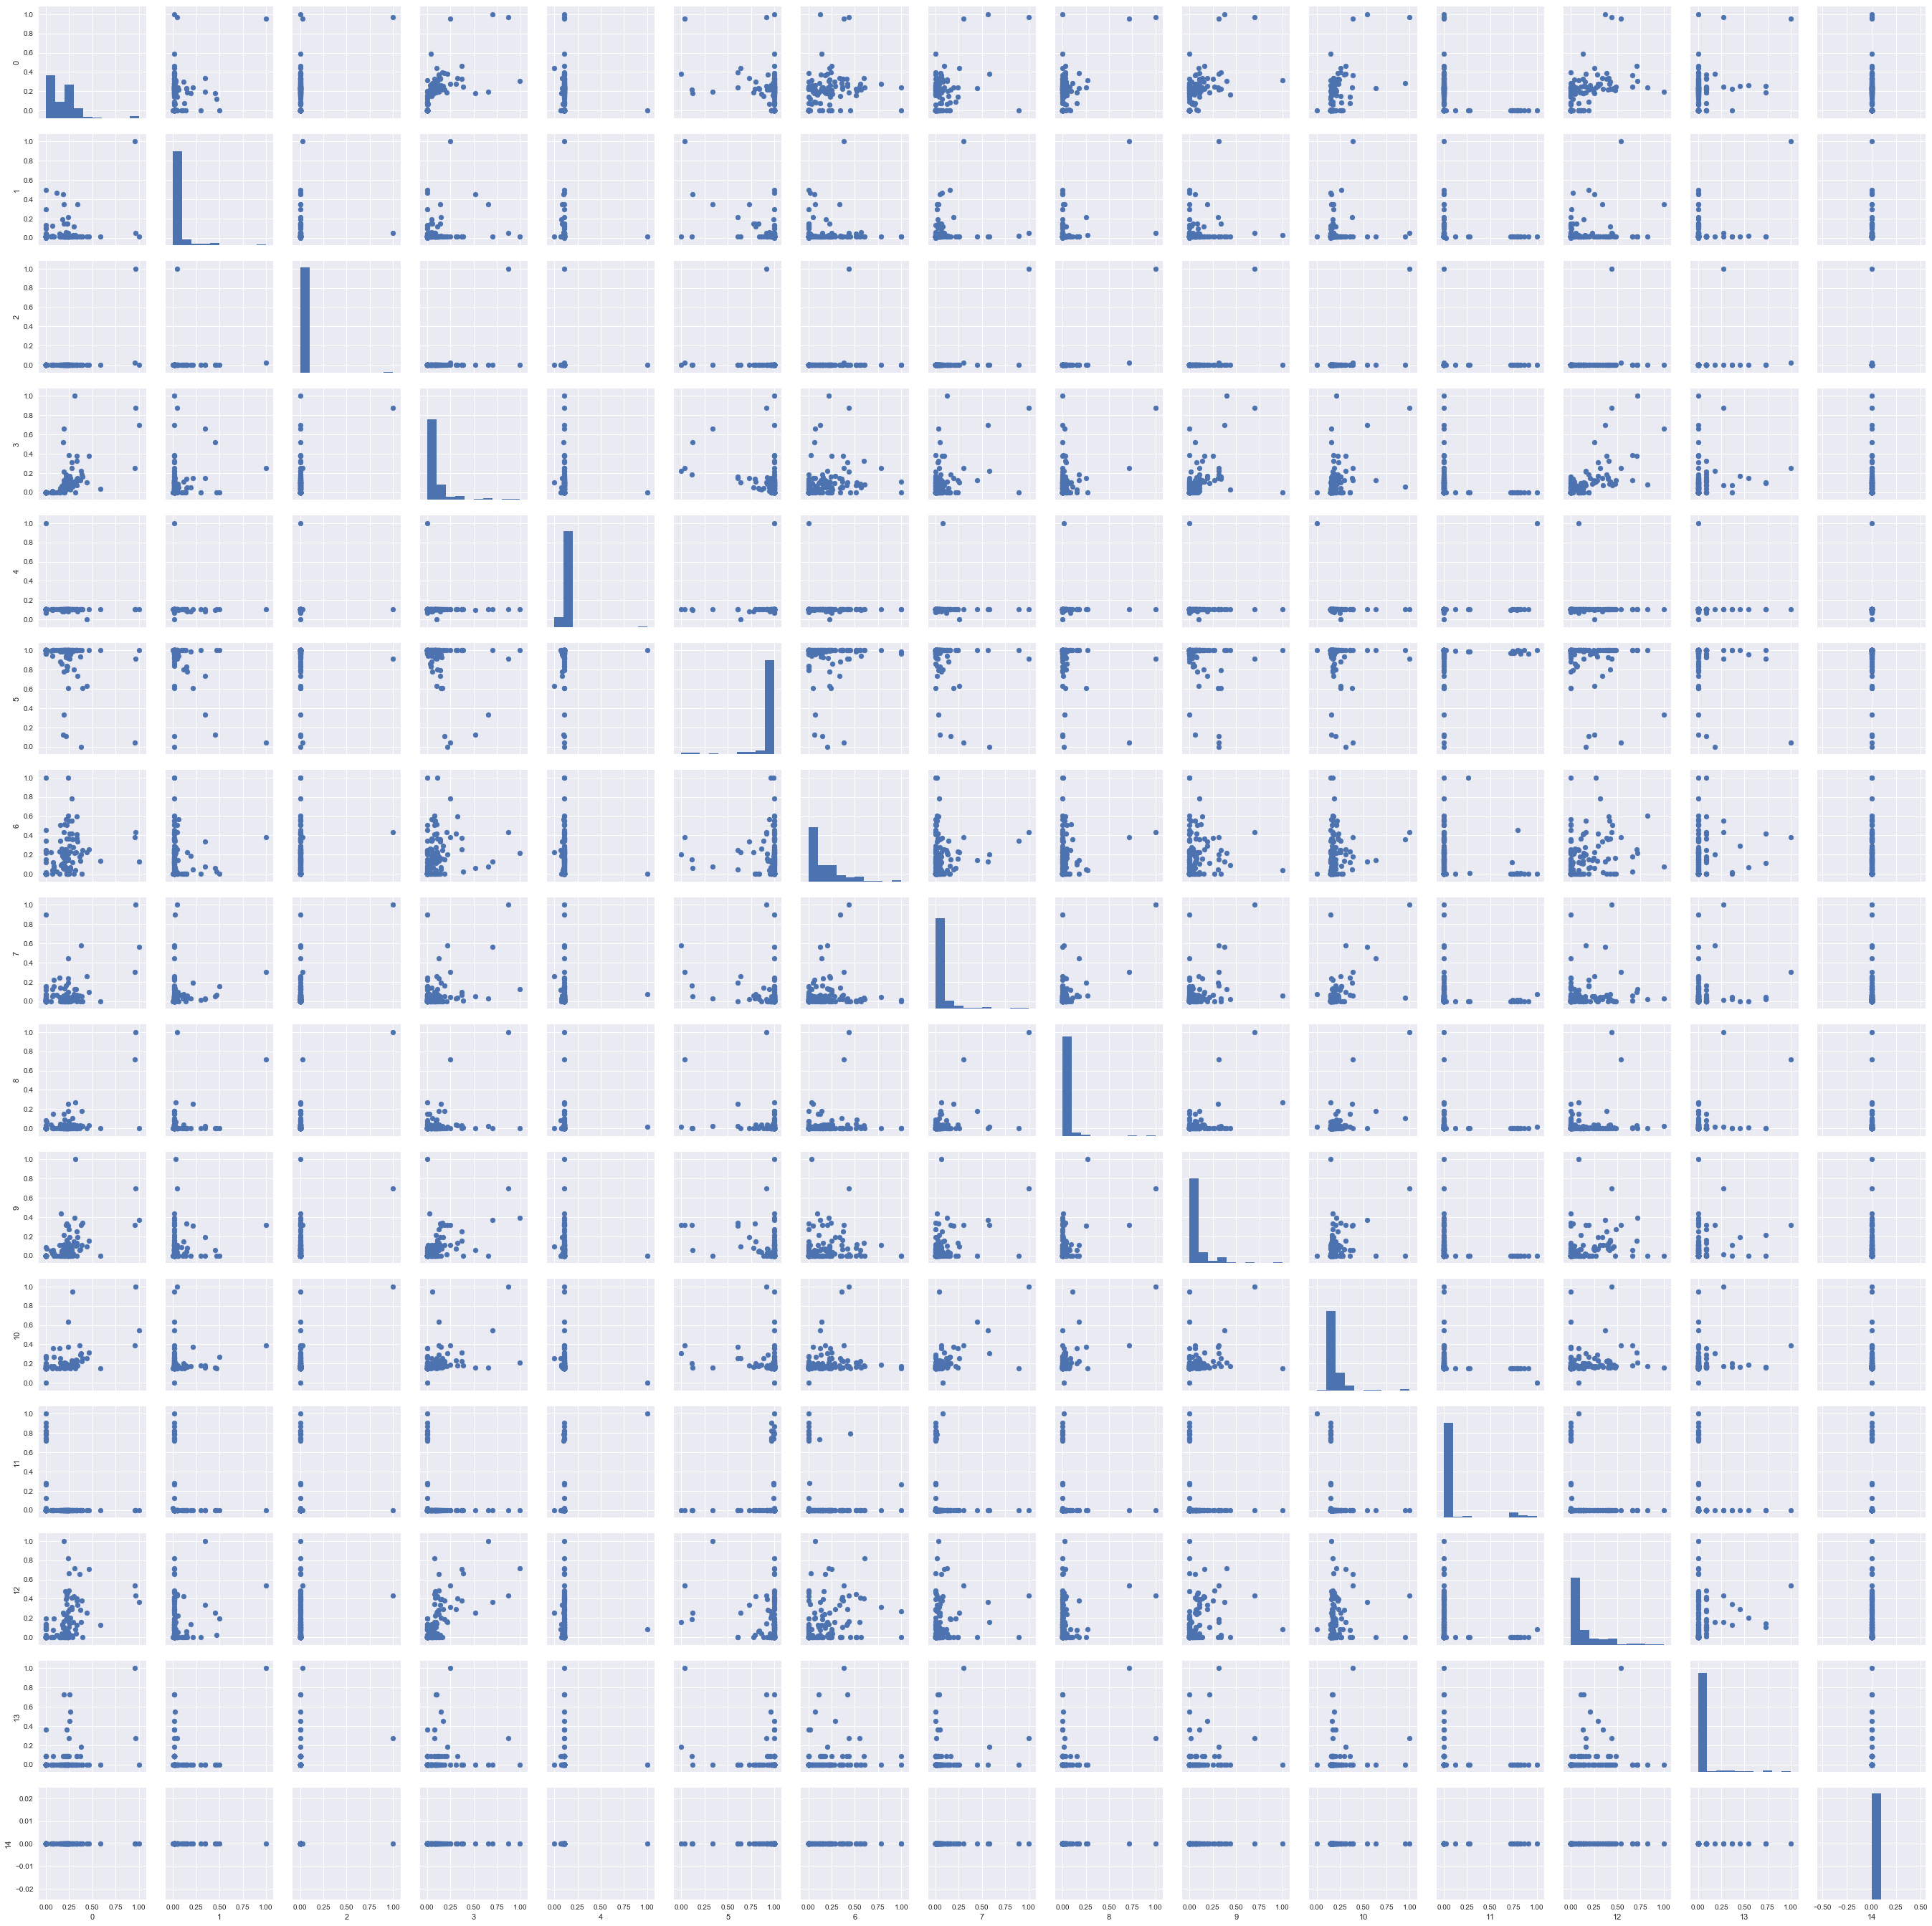

In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(X_std)
pg = sns.PairGrid(df)
pg.map_diag(plt.hist)
pg.map_offdiag(plt.scatter)
plt.show()

#  Logistic Regression

In [ ]:
clf_labels = \
['Logistic Regression','KNN','Random Forest','SVC','Kernel SVC','MLP']

#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#Logistic Regression
scores=[]
clf_lr = LogisticRegression(penalty='l2')
pipe_lr = Pipeline([['sc',MinMaxScaler()],
                    ['kbest',SelectKBest(chi2,k=8)],
                    ['clf',clf_lr]])
params_lr = {'clf__C':10.0**np.arange(-4,4)}
t0 = time()
for i in range(N_outer):
    k_fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        k_fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_lr = GridSearchCV(estimator=pipe_lr,param_grid=params_lr,
                             cv=k_fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_lr,X,y,cv=k_fold_outer,
                                      scoring='f1'))
print 'CV F1 Score of Logistic Regression: %.3f +/- %.3f' %(np.mean(scores),np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)
        
t0 = time()
for i in range(N_outer):
    k_fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        k_fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_lr = GridSearchCV(estimator=pipe_lr,param_grid=params_lr,
                             cv=k_fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_lr,X,y,cv=k_fold_outer,
                                      scoring='precision'))
print 'CV Precision Score of Logistic Regression: %.3f +/- %.3f' %(np.mean(scores),np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)
        
t0 = time()
for i in range(N_outer):
    k_fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        k_fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_lr = GridSearchCV(estimator=pipe_lr,param_grid=params_lr,
                             cv=k_fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_lr,X,y,cv=k_fold_outer,
                                      scoring='recall'))
        
print 'CV Recall Score of Logistic Regression: %.3f +/- %.3f' %(np.mean(scores),np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)

CV F1 Score of Logistic Regression: 0.191 +/- 0.198
Complete in 43.4 sec
CV Precision Score of Logistic Regression: 0.252 +/- 0.311
Complete in 41.2 sec
CV Recall Score of Logistic Regression: 0.218 +/- 0.274
Complete in 40.9 sec


#  Random Forest Classifier

In [ ]:
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#Random Forest Classifier
scores=[]
clf_rf = RandomForestClassifier(random_state=42)
pipe_rf = Pipeline([['sc',MinMaxScaler()],
                    ['kbest',SelectKBest(chi2,k=8)],
                    ['clf',clf_rf]])
params_rf = {'clf__n_estimators':np.arange(1,11)}
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=params_rf,
                             cv=fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_rf,X,y,cv=fold_outer,
                                      scoring='f1'))
print ('CV F1 Score of Random Forest Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=params_rf,
                             cv=fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_rf,X,y,cv=fold_outer,
                                      scoring='precision'))
print ('CV Precision Score of Random Forest Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=params_rf,
                             cv=fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_rf,X,y,cv=fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of Random Forest Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

CV F1 Score of Random Forest Classifier: 0.204 +/- 0.196
Complete in 201.3 sec
CV Precision Score of Random Forest Classifier: 0.256 +/- 0.308
Complete in 410.3 sec


#  KNN Classifier

In [ ]:
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#KNN Classifier
scores=[]
clf_knn = KNeighborsClassifier()
pipe_knn = Pipeline([['sc',MinMaxScaler()],
                     ['kbest',SelectKBest(chi2,k=8)],
                     ['clf',clf_knn]])
params_knn = {'clf__n_neighbors':np.arange(1,6)}
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_knn = GridSearchCV(estimator=pipe_knn,param_grid=params_knn,
                              cv=fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_knn,X,y,cv=fold_outer,
                                      scoring='f1'))
print ('CV F1 Score of KNN Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_knn = GridSearchCV(estimator=pipe_knn,param_grid=params_knn,
                              cv=fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_knn,X,y,cv=fold_outer,
                                      scoring='precision'))
print ('CV Precision Score of KNN Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_knn = GridSearchCV(estimator=pipe_knn,param_grid=params_knn,
                              cv=fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_knn,X,y,cv=fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of KNN Classifier: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

#  Linear SVC

In [ ]:
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#Linear SVC
scores=[]
clf_svc = SVC()
pipe_svc = Pipeline([['sc',MinMaxScaler()],
                     ['kbest',SelectKBest(chi2,k=8)],
                     ['clf',clf_svc]])
params_svc = {'clf__C':10.0**np.arange(-4,4)}
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_svc = GridSearchCV(estimator=pipe_svc,param_grid=params_svc,
                              cv=fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_svc,X,y,cv=fold_outer,
                                      scoring='f1'))
print ('CV F1 Score of Linear SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_svc = GridSearchCV(estimator=pipe_svc,param_grid=params_svc,
                              cv=fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_svc,X,y,cv=fold_outer,
                                      scoring='precision'))
print ('CV Precision Score of Linear SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_svc = GridSearchCV(estimator=pipe_svc,param_grid=params_svc,
                              cv=fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_svc,X,y,cv=fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of Linear SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

#  Kernel SVC

In [ ]:
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#Kernel SVC
scores=[]
clf_ksvc = SVC(kernel='rbf')
pipe_ksvc = Pipeline([['sc',MinMaxScaler()],
                      ['kbest',SelectKBest(chi2,k=8)],
                      ['clf',clf_ksvc]])
params_ksvc = {'clf__C':10.0**np.arange(-4,4),'clf__gamma':10.0**np.arange(-4,4)}
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_ksvc = GridSearchCV(estimator=pipe_ksvc,param_grid=params_ksvc,
                               cv=fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_ksvc,X,y,cv=fold_outer,
                                      scoring='f1'))
print ('CV F1 Score of Kernel SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_ksvc = GridSearchCV(estimator=pipe_ksvc,param_grid=params_ksvc,
                               cv=fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_ksvc,X,y,cv=fold_outer,
                                      scoring='precision'))
print ('CV Precision Score of Kernel SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_ksvc = GridSearchCV(estimator=pipe_ksvc,param_grid=params_ksvc,
                               cv=fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_ksvc,X,y,cv=fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of Kernel SVC: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

#  Naive Bayes

In [ ]:
#Set the number of repeats of the cross validation
N_outer = 5

#Naive Bayes
scores=[]
clf_nb = GaussianNB()
pipe_nb = Pipeline([['sc',MinMaxScaler()],
                    ['kbest',SelectKBest(chi2,k=8)],
                    ['clf',clf_nb]])
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    scores.append(cross_val_score(pipe_nb,X,y,cv=fold_outer,
                                      scoring='f1'))
print 'CV F1 Score of Naive Bayes: %.3f +/- %.3f' %(np.mean(scores),
                                                               np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    scores.append(cross_val_score(pipe_nb,X,y,cv=fold_outer,
                                      scoring='precision'))
print 'CV Precision Score of Naive Bayes: %.3f +/- %.3f' %(np.mean(scores),
                                                               np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    scores.append(cross_val_score(pipe_nb,X,y,cv=fold_outer,
                                      scoring='recall'))
print 'CV Recall Score of Naive Bayes: %.3f +/- %.3f' %(np.mean(scores),
                                                               np.std(scores))
print 'Complete in %.1f sec' %(time()-t0)

#  Multi-Layer Perceptron

In [ ]:
#Set the number of repeats of the cross validation
N_outer = 5
N_inner = 5

#Kernel SVC
scores=[]
clf_mlp = MLPClassifier(solver='lbfgs')
pipe_mlp = Pipeline([['sc',MinMaxScaler()],
                     ['kbest',SelectKBest(chi2,k=8)],
                     ['clf',clf_mlp]])
params_mlp = {'clf__activation':['logistic','relu'],'clf__alpha':10.0**np.arange(-4,4)}
t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_mlp = GridSearchCV(estimator=pipe_mlp,param_grid=params_mlp,
                               cv=fold_inner,scoring='f1')
        scores.append(cross_val_score(gs_mlp,X,y,cv=fold_outer,
                                      scoring='f1'))
print ('CV F1 Score of MLP: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_mlp = GridSearchCV(estimator=pipe_mlp,param_grid=params_mlp,
                               cv=fold_inner,scoring='precision')
        scores.append(cross_val_score(gs_mlp,X,y,cv=fold_outer,
                                      scoring='precision'))
print ('CV Precision of MLP: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)

t0 = time()
for i in range(N_outer):
    fold_outer = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
    for j in range(N_inner):
        fold_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=j)
        gs_mlp = GridSearchCV(estimator=pipe_mlp,param_grid=params_mlp,
                               cv=fold_inner,scoring='recall')
        scores.append(cross_val_score(gs_mlp,X,y,cv=fold_outer,
                                      scoring='recall'))
print ('CV Recall Score of MLP: %.3f +/- %.3f'
       %(np.mean(scores), np.std(scores)))
print 'Complete in %.1f sec' %(time()-t0)